<a href="https://colab.research.google.com/github/ghostflare76/openllm/blob/main/reddit_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet --upgrade langchain langchain-google-genai cache-pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 3.2 MB/s eta 0:00:00


In [2]:
## Local 에서 수행시에는 API 키 정보 로드 및 환경 변수에서 값을 불러옴

from google.colab import userdata

GOOGLE_API_KEY=userdata.get("GOOGLE_API_KEY")
REDDIT_USERNAME=userdata.get("REDDIT_USERNAME")
REDDIT_PASSWORD=userdata.get("REDDIT_PASSWORD")
REDDIT_CLIENT_ID=userdata.get("REDDIT_CLIENT_ID")
REDDIT_CLIENT_SECRET=userdata.get("REDDIT_CLIENT_SECRET")


In [3]:
import requests
import pandas as pd
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage

In [4]:
class Post:
    def __init__(self, title, selftext, commentcnt, score, url):
        self.title = title
        self.selftext = selftext
        self.commentcnt = commentcnt
        self.score = score
        self.url = url

    def __str__(self):
        return f"Title: {self.title}\nSelftext: {self.selftext}\nCommentCnt: {self.commentcnt}\nScore: {self.score}\nUrl : {self.url}\n"

# Reddit 계정정보를 이용하여 Token 정보 획득

In [5]:
from cache_pandas import timed_lru_cache

@timed_lru_cache(seconds=60*60*24, maxsize=None)
def get_access_token() -> str:
    token_url = f"https://www.reddit.com/api/v1/access_token?grant_type=password&username={REDDIT_USERNAME}&password={REDDIT_PASSWORD}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }

    response = requests.post(token_url, auth=(REDDIT_CLIENT_ID, REDDIT_CLIENT_SECRET), headers=headers)

    if response.status_code != 200:
        print(f"Error acquiring access token: {response.status_code} - {response.text}")
        return None

    return response.json()["access_token"]




# 토큰을 이용하여 최신 리뷰 목록 조회

In [8]:
@timed_lru_cache(seconds=60*60*6, maxsize=None)
def get_new_posts():

    access_token = get_access_token()
    if not access_token:
        return None

    url = "https://oauth.reddit.com/r/throneandliberty/new?limit=40"
    headers = {
        "Authorization": f"Bearer {access_token}",
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }

    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Error fetching new posts: {response.status_code} - {response.text}")
        return None

    return response.json()

In [9]:
import json
new_posts = get_new_posts()
if new_posts:
    print(json.dumps(new_posts["data"]["children"][0], indent=2))

{
  "kind": "t3",
  "data": {
    "approved_at_utc": null,
    "subreddit": "throneandliberty",
    "selftext": "When I have 2 mobs on me and I tab usually pick something else that is way far away!\nEven do inset it up as default where is circular by proximity... Any one else experience this?",
    "author_fullname": "t2_4h7n1x",
    "saved": false,
    "mod_reason_title": null,
    "gilded": 0,
    "clicked": false,
    "title": "Tab Target doesn't really work :(",
    "link_flair_richtext": [],
    "subreddit_name_prefixed": "r/throneandliberty",
    "hidden": false,
    "pwls": 7,
    "link_flair_css_class": null,
    "downs": 0,
    "thumbnail_height": null,
    "top_awarded_type": null,
    "hide_score": false,
    "name": "t3_1ckza2h",
    "quarantine": false,
    "link_flair_text_color": "dark",
    "upvote_ratio": 0.67,
    "author_flair_background_color": null,
    "subreddit_type": "public",
    "ups": 1,
    "total_awards_received": 0,
    "media_embed": {},
    "thumbnail_w

In [10]:
posts = [Post(item['data']['title'], item['data']['selftext'], item['data']['num_comments'], item['data']['score'], item['data']['url']) for item in new_posts['data']['children']]

In [11]:
llm = ChatGoogleGenerativeAI(
    model="gemini-pro",
    google_api_key=GOOGLE_API_KEY
)

# 주어진 본문 내용 바탕으로 감정 분석후 3가지로 분류

In [12]:

def get_sentiment(text):
    prompt = HumanMessage(content=f"Analyze the sentiment of the following text: '{text}'. Return 'positive', 'negative', or 'neutral' based on the sentiment analysis.")
    response = llm([prompt])
    sentiment = response.content.strip().lower()

    if 'positive' in sentiment:
        return 'positive'
    elif 'negative' in sentiment:
        return 'negative'
    else:
        return 'neutral'


# 주어진 TEXT 기반으로 주요 keyword 5개를 추출

In [13]:

def get_keyword(text):
    prompt = HumanMessage(content=f"Extract negative keywords that matter from the given text: '{text}'. Return list them separated by commas.")
    response = llm([prompt])
    return response.content.strip().lower()


In [14]:
import time

def process_post(post):
    text = post.selftext
    sentiment = get_sentiment(text)
    if sentiment == 'negative':
        keyword = get_keyword(text)
    else:
        keyword = 'N/A'
    post_with_sentiment = {
        'title': post.title,
        'text': post.selftext,
        'commentcnt': post.commentcnt,
        'score': post.score,
        'sentiment': sentiment,
        'keyword' : keyword,
        'url': post.url
    }
    return post_with_sentiment

In [15]:
posts_with_sentiments = []

# LLM 수행중에 SAFETY 관련 오류 발생시 예외 처리를 위해 Exception 처리 필요
for post in posts:
    try:
        post_with_sentiment = process_post(post)
    except Exception as e:
        print (f"An error occured : {e}")
        continue

    posts_with_sentiments.append(post_with_sentiment)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


An error occured : finish_reason: SAFETY
index: 0
safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: MEDIUM
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}

An error occured : finish_reason: SAFETY
index: 0
safety_ratings {
  category: HARM_CATEGORY_SEXUALLY_EXPLICIT
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HATE_SPEECH
  probability: NEGLIGIBLE
}
safety_ratings {
  category: HARM_CATEGORY_HARASSMENT
  probability: MEDIUM
}
safety_ratings {
  category: HARM_CATEGORY_DANGEROUS_CONTENT
  probability: NEGLIGIBLE
}



In [16]:
df = pd.DataFrame(posts_with_sentiments)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       38 non-null     object
 1   text        38 non-null     object
 2   commentcnt  38 non-null     int64 
 3   score       38 non-null     int64 
 4   sentiment   38 non-null     object
 5   keyword     38 non-null     object
 6   url         38 non-null     object
dtypes: int64(2), object(5)
memory usage: 2.2+ KB


In [18]:
review_list = []

for review in df['text']:
  split= review.split()
  review_list.append(split)


리뷰의 최대 단어 수 : 250
리뷰의 평균 단어 수 : 42.5


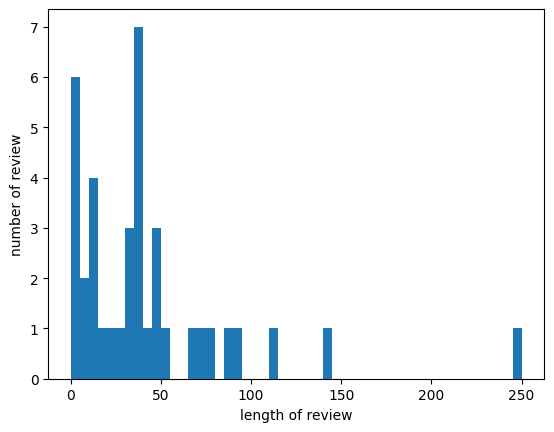

In [19]:
import matplotlib.pyplot as plt

print('리뷰의 최대 단어 수 :', max(len(review) for review in review_list))
print('리뷰의 평균 단어 수 :', sum(map(len, review_list))/len(review_list))
plt.hist([len(review) for review in review_list], bins=50)
plt.xlabel('length of review')
plt.ylabel('number of review')
plt.show()

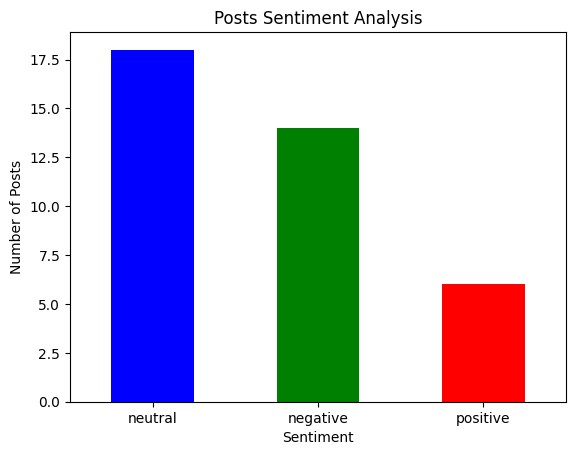

In [20]:

import matplotlib.pyplot as plt
sentiment_counts = df['sentiment'].value_counts()


sentiment_counts.plot(kind='bar', color=['blue', 'green', 'red'])

plt.title('Posts Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.xticks(rotation=0)
plt.show()

In [22]:
from collections import Counter
import pandas as pd

all_keywords = ' '.join(df['keyword'].replace('N/A', ''))

keyword_counts = Counter(all_keywords.split())
top_keywords = dict(keyword_counts.most_common(20))



In [24]:
display(top_keywords)

{'not': 3,
 'for': 2,
 'inefficient': 2,
 'game,': 2,
 'to': 2,
 'far': 1,
 'away': 1,
 'broken': 1,
 'killing': 1,
 'mobs,': 1,
 'base': 1,
 'in': 1,
 'damage,': 1,
 'horrible,': 1,
 'soni': 1,
 'get': 1,
 'almost': 1,
 'none': 1,
 'gold/sollant,': 1,
 'gearing': 1}

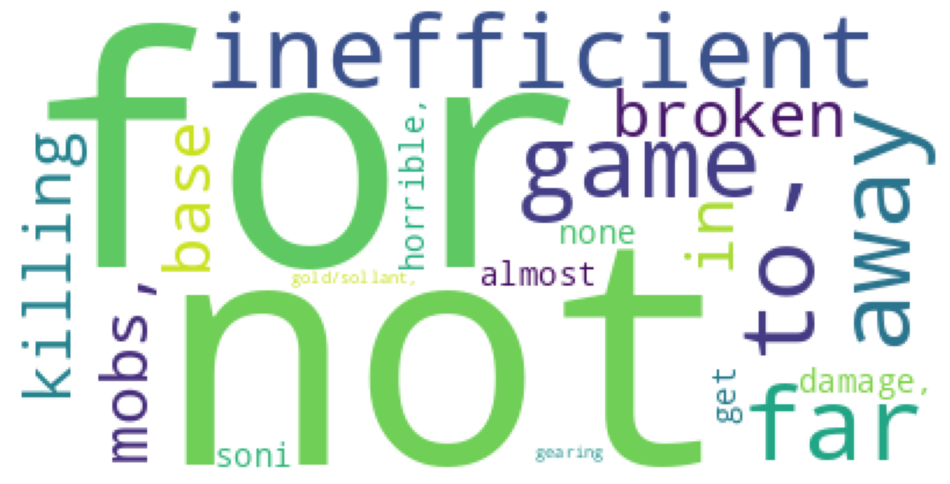

In [23]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
# 3. 워드 클라우드 생성
wordcloud = WordCloud(relative_scaling=0,background_color='white', stopwords=STOPWORDS).generate_from_frequencies(top_keywords)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()